In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from get_data import load_data
import numpy as np
import random
import cv2

In [2]:
X, y = load_data()

In [3]:
X_ = []
for x in X:
    X_.append((x-255)/255)
X = X_

In [4]:
X, y = np.asarray(X), np.asarray(y)

In [5]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [6]:
X[0].shape

(32, 32, 1)

In [7]:
class_bins = {0: 'shake_hands',
             1: 'hug',
             2: 'kick',
             3: 'point',
             4: 'punch',
             5: 'push'}

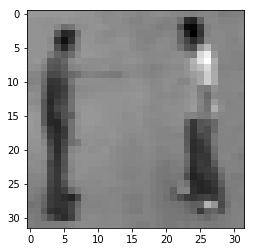

Class -> shake_hands, (0)


In [9]:
rand_int = random.randint(0, len(X)-1)
plt.imshow(X[rand_int][:,:,0], cmap='gray')
plt.show()
print(f"Class -> {class_bins[y[rand_int]]}, ({y[rand_int]})")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [11]:
print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 1)

Training Set:   3877 samples
Test Set:       1910 samples


In [12]:
import tensorflow as tf

/home/muhsin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
EPOCHS = 100
BATCH_SIZE = 128
class_nums = 6

In [14]:
X_train, y_train = shuffle(X_train, y_train)

In [15]:
X_train = np.asarray(X_train)

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, class_nums)

In [17]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    
    ## Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    ## Activation.
    conv1 = tf.nn.relu(conv1)

    ## Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    ## Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    ## Activation.
    conv2 = tf.nn.relu(conv2)

    ## Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    ## Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    ## Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    ## Activation.
    fc1 = tf.nn.relu(fc1)

    ## Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    ## Activation.
    fc2 = tf.nn.relu(fc2)
    
    ## Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84, class_nums), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(class_nums))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

In [18]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}/".format(validation_accuracy))
        print()
        
    saver.save(sess, './model/lenet_full_data')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.331/

EPOCH 2 ...
Validation Accuracy = 0.353/

EPOCH 3 ...
Validation Accuracy = 0.421/

EPOCH 4 ...
Validation Accuracy = 0.454/

EPOCH 5 ...
Validation Accuracy = 0.496/

EPOCH 6 ...
Validation Accuracy = 0.554/

EPOCH 7 ...
Validation Accuracy = 0.592/

EPOCH 8 ...
Validation Accuracy = 0.615/

EPOCH 9 ...
Validation Accuracy = 0.639/

EPOCH 10 ...
Validation Accuracy = 0.698/

EPOCH 11 ...
Validation Accuracy = 0.719/

EPOCH 12 ...
Validation Accuracy = 0.782/

EPOCH 13 ...
Validation Accuracy = 0.824/

EPOCH 14 ...
Validation Accuracy = 0.791/

EPOCH 15 ...
Validation Accuracy = 0.855/

EPOCH 16 ...
Validation Accuracy = 0.891/

EPOCH 17 ...
Validation Accuracy = 0.880/

EPOCH 18 ...
Validation Accuracy = 0.916/

EPOCH 19 ...
Validation Accuracy = 0.920/

EPOCH 20 ...
Validation Accuracy = 0.932/

EPOCH 21 ...
Validation Accuracy = 0.941/

EPOCH 22 ...
Validation Accuracy = 0.946/

EPOCH 23 ...
Validation Accuracy = 0.952/

EPOCH 2

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from ./model/lenet_full_data
Test Accuracy = 0.986
Train Accuracy = 1.000


1300


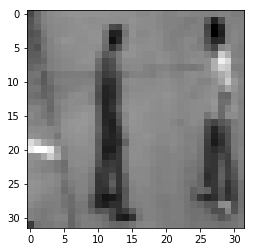

Actual Class -> push, (5)
INFO:tensorflow:Restoring parameters from ./model/lenet_full_data
[[-11.79307175  -2.65925312   3.66619968 -25.21070099  -2.62715244
   15.7318449 ]]

Model prediction -> push, (5)


In [25]:
## inference on random test image
rand_int = random.randint(0, len(X_test)-1)
print(rand_int)
plt.imshow(X_test[rand_int][:,:,0], cmap='gray')
plt.show()
print(f"Actual Class -> {class_bins[y_test[rand_int]]}, ({y_test[rand_int]})")

test_img = X_test[rand_int]
dim = test_img.shape
test_img = test_img.reshape(1, dim[0], dim[1], dim[2])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    output = sess.run(logits, feed_dict={x: test_img})
    print(output)
    print()
    print(f'Model prediction -> {class_bins[y_test[rand_int]]}, ({np.argmax(output)})')

In [26]:
##### ext data

In [27]:
def imgPreprocessor(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Size of original images
    # max-min range --> (332-216, 612, 244)
    # avg range --> (260, 380)
    img_gray = cv2.resize(img_gray, (70, 95))
    img_gauss = cv2.GaussianBlur(img_gray, (5,5), 0)
    img_norm = np.empty_like((img_gauss))
    img_norm = cv2.normalize(img_gauss, img_norm, 0, 255, cv2.NORM_MINMAX)
    return img_norm

In [28]:
def writeImg(img):
    cv2.imwrite(file_loc, img)

In [33]:
dir_ext = './data/img_data_seg_1/4_5_29.png'

In [34]:
file_name="just_a_test_img.png"
loc_dst="./"
file_loc = loc_dst + file_name

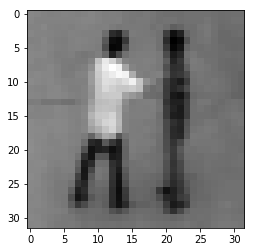

INFO:tensorflow:Restoring parameters from ./model/lenet_full_data
[[-13.76380157   1.02973628 -14.2287693  -35.41995621  18.6151371
    0.24918836]]

Model prediction -> punch, (4)


In [35]:
img = imgPreprocessor(cv2.imread(dir_ext))
writeImg(img)

img = cv2.imread(file_loc)
img = cv2.resize(img, (32, 32))
img = img[:,:,0]
img = ((img-255)/255)

plt.imshow(img, cmap='gray')
plt.show()

test_img = img
test_img = test_img.reshape(1, 32, 32, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    output = sess.run(logits, feed_dict={x: test_img})
    print(output)
    print()
    print(f'Model prediction -> {class_bins[np.argmax(output)]}, ({np.argmax(output)})')

In [36]:
sess.close()